# 기존 이미지를 다른 스타일의 이미지로 구성하기

## Module Import

In [88]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
tfk = tf.keras
tfkm = tfk.models

In [89]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
# import functools

In [90]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [91]:
content_path = '/Users/anmunju/Documents/0_munju/mungdo/TIL/2022/202211/20221125/sample_imgs/content.png'
style_path = '/Users/anmunju/Documents/0_munju/mungdo/TIL/2022/202211/20221125/sample_imgs/style2.png'

## 입력 시각화

In [92]:
def load_img(path_to_img):
  max_dim = 256
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, (256, 256))
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

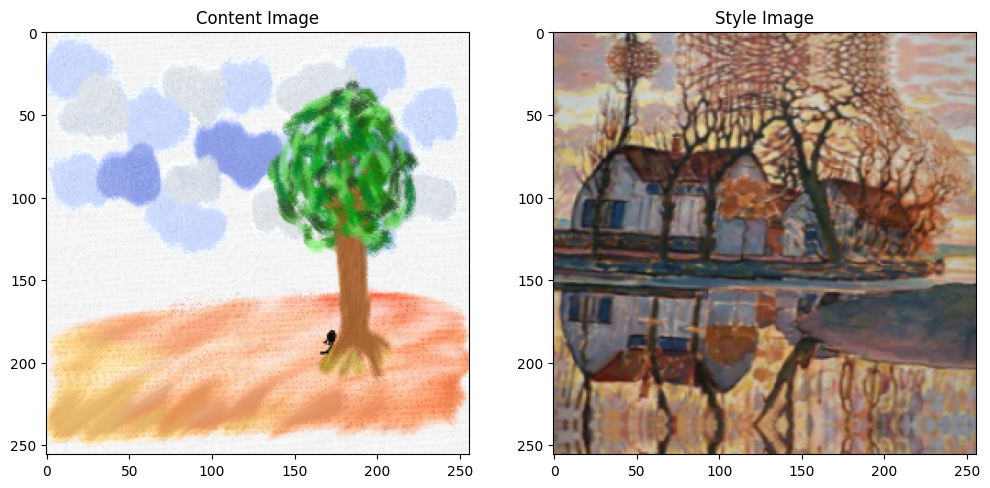

In [93]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## 내가 만든 사조 분류 모델을 이용해 Style Transfer 만들기

### 사조 분류 embedding 모델 불러오기

In [94]:
e_model = tfkm.load_model('embedding_model')

In [96]:
# e_model.summary()

In [97]:
for layer in e_model.layers:
  print(layer.name)

input_2
tf.math.truediv
tf.math.subtract
mobilenetv2_1.00_224
rescaling_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
activation_2
separable_conv2d
batch_normalization_2
max_pooling2d
conv2d_2
add
activation_3
separable_conv2d_1
batch_normalization_3
max_pooling2d_1
conv2d_3
add_1
dropout
separable_conv2d_2
batch_normalization_4
activation_4
global_average_pooling2d_1
dropout_1


In [98]:
content_layers = ['global_average_pooling2d_1'] 

style_layers = ['conv2d',
                'conv2d_1',
                'conv2d_2', 
                'conv2d_3']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### 모델 만들기

In [99]:
def emodel_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  e_model.trainable = False
  
  outputs = [e_model.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([e_model.input], outputs)
  return model

In [100]:
style_extractor = emodel_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

conv2d
  shape:  (1, 4, 4, 32)
  min:  -0.055521604
  max:  0.028644504
  mean:  -0.003974273

conv2d_1
  shape:  (1, 4, 4, 64)
  min:  -0.48650298
  max:  0.36399853
  mean:  -0.010098101

conv2d_2
  shape:  (1, 2, 2, 128)
  min:  -1.292739
  max:  1.396345
  mean:  -0.097453065

conv2d_3
  shape:  (1, 1, 1, 512)
  min:  -2.4362886
  max:  0.7405389
  mean:  -0.6727137



### 스타일 계산하기

In [101]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### 스타일과 콘텐츠 추출

In [102]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = emodel_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [103]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   conv2d
    shape:  (1, 32, 32)
    min:  -0.00042505344
    max:  0.00079269893
    mean:  1.9452655e-05

   conv2d_1
    shape:  (1, 64, 64)
    min:  -0.07492473
    max:  0.09655691
    mean:  0.0009678915

   conv2d_2
    shape:  (1, 128, 128)
    min:  -1.0306727
    max:  1.5716115
    mean:  0.020808939

   conv2d_3
    shape:  (1, 512, 512)
    min:  -2.766406
    max:  5.320175
    mean:  0.547946

Contents:
   global_average_pooling2d_1
    shape:  (1, 1024)
    min:  0.0
    max:  2.079746
    mean:  0.26018965


### 경사하강법 실행

In [104]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [105]:
image = tf.Variable(content_image)

In [106]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [107]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [108]:
style_weight=1e-2
content_weight=1e4

In [109]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [110]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

2022-11-28 09:55:15.724480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


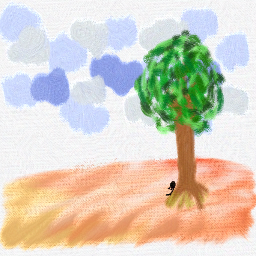

In [111]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

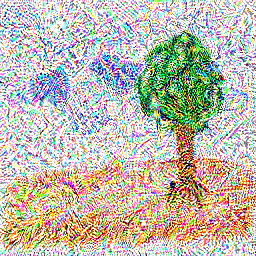

Train step: 1000
Total time: 29.4


In [112]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

## 총 변위 손실

In [113]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

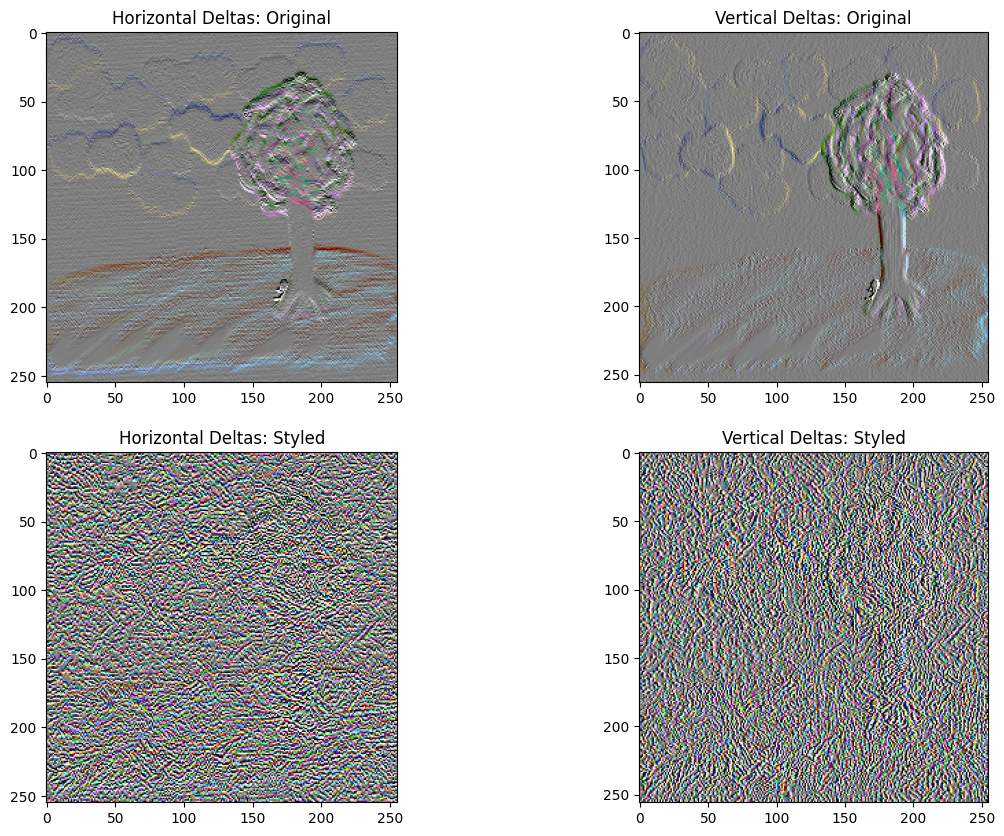

In [114]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

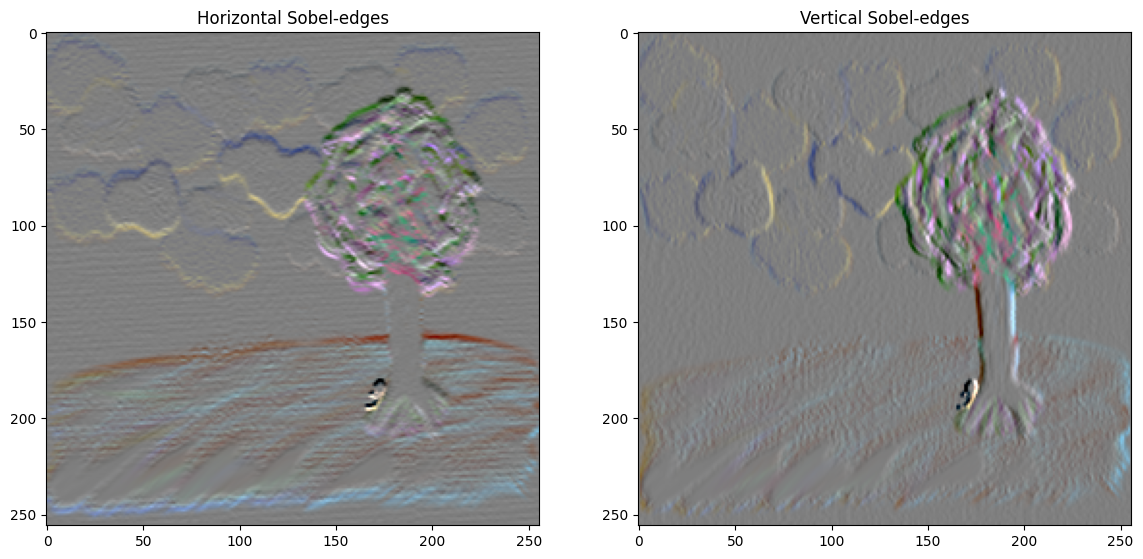

In [115]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [118]:
tf.image.total_variation(image).numpy()

array([84391.55], dtype=float32)

## 다지 최적화하기

In [119]:
total_variation_weight=30

In [120]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [121]:
image = tf.Variable(content_image)

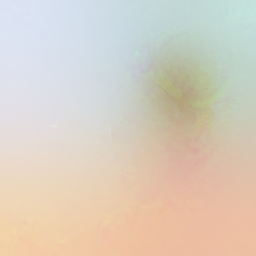

Train step: 1000
Total time: 31.2


In [122]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))